# Multiple Network Models

Up to this point, we have studied network models which are useful for a single network. What do we do if we have multiple networks?

Let's imagine that we have a company with $45$ total employees. This company is a *real* innovator, and is focused on developing software for network machine learning for business use. $10$ of these employees are company administrative executives, $25$ of these employees are network machine learning experts, and $10$ of these employees are marketing experts. For each day over the course of a full $30$-day month, we study the emails that go back and forth between the employees in the company. We summarize the emailing habits within the company using a nework, where the nodes of the network are employees, and the edges indicate the emailing behaviors between each pair of employees. An edge is said to exist if the two employees have exchanged an email on that day, and an edge does not exist if the two employees have not exchanged an email on that day. In most companies, it is common for employees in a similar role to tend to work more closely together, so we might expect that there is some level of a community structure to the emailing habits. For instance, if two employees are both network machine learning experts, they might exchange more emails between one another than a machine learning expert and a marketing expert. For the sake of this example, we will assume that the networks are organized such that the first day is a Monday, the second day is a Tuesday, so on and so forth. Let's take a look at an example of some possible realizations of the first $3$ days worth of emails. What we will see below is that all of the networks appear to have the same community organization, though on Wednesday, we will assume there was an executive board meeting, and in the morning leading up to the board meeting, the administrative executives of the company exchanged more emails than on other days. This is reflected in the fact that there are more emails going back and forth between administrative members in the network for "Wednesday":

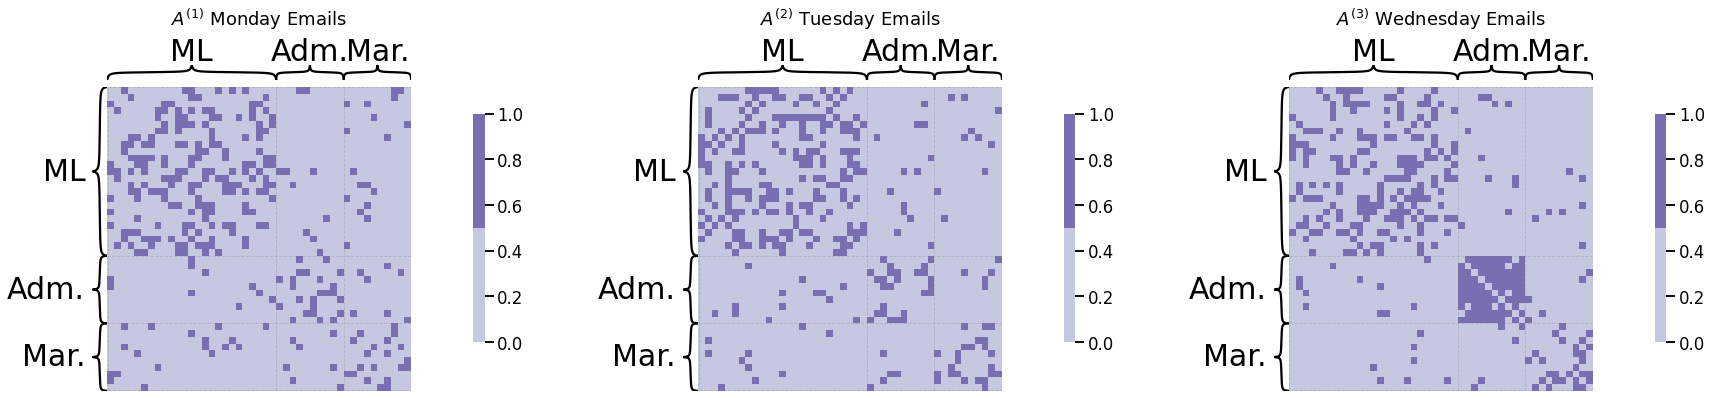

In [1]:
from graphbook_code import heatmap
from graspologic.simulations import sbm
import numpy as np
import matplotlib.pyplot as plt

K = 3

B1 = np.zeros((K,K))

B1[0,0] = 0.3
B1[0,1] = .05
B1[1,0] = .05
B1[0,2] = .05
B1[2,0] = .05
B1[1,1] = 0.3
B1[1,2] = .05
B1[2,1] = .05
B1[2,2] = 0.3

B2 = B1

B3 = np.copy(B1)
B3[1,1] = 0.9

ns = [25, 10, 10]
A1 = sbm(n=ns, p=B1, directed=False, loops=False)
ys = ["ML" for i in range(0, ns[0])] + ["Adm." for i in range(ns[0],ns[0] + ns[1])] + ["Mar." for i in range(ns[0] + ns[1],ns[0] + ns[1] + ns[2])]

A2 = sbm(n=ns, p=B2, directed=False, loops=False)

A3 = sbm(n=ns, p=B3, directed=False, loops=False)

fig, axs = plt.subplots(1,3, figsize=(30, 6))

heatmap(A1, ax=axs[0], title="$A^{(1)}$ Monday Emails", color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);

heatmap(A2, ax=axs[1], title="$A^{(2)}$ Tuesday Emails", color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);

heatmap(A3, ax=axs[2], title="$A^{(3)}$ Wednesday Emails", color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);

Remember that a random network has an adjacency matrix denoted by a boldfaced uppercase $\mathbf A$, and has network realizations $A$ (which we just call "networks"). When we have multiple networks, we will need to be able to index them individually. For this reason, in this section, we will use the convention that a random network's adjacency matrix is denoted by a boldfaced uppercase $\mathbf A^{(m)}$, where $m$ tells us which network in our collection we are talking about. The capital letter $N$ defines the *total* number of random networks in our collection. In our email example, since we have email networks for $30$ days, $N$ is $30$. When we use the letter $m$ itself, we will typically be referring to an arbitrary random network amongst the collection of random networks, where $m$ beween $1$ and $N$. When we have $N$ total networks, we will write down the entire **collection of random networks** using the notation $\left\{\mathbf A^{(1)}, ..., \mathbf A^{(N)}\right\}$. With what we already know, for a random network $\mathbf A^{(m)}$, we would be able to use a single nework model to describe $\mathbf A^{(m)}$. This means, for instance, if we thought that each email network could be represented by an RDPG, that we would have a *different* latent position matrix $X^{(m)}$ to define each of the $30$ networks. In symbols, we would write that each $\mathbf A^{(m)}$ is an RDPG random nework with latent position matrix $X^{(m)}$. What is the problem with this description?

What this description lacks is that, over the course of a given $30$ days, a *lot* of the networks are going to show similar emailing patterns. We might expect that this implies that, on some level, the latent position matrices should also show some sort of common structure. However, since we used a *unique* latent position matrix $X^{(m)}$ for each random network $\mathbf A^{(m)}$, we have inherently stated that we think that the networks have completely distinct latent position matrices. If we were to perform a task downstream, such as whether we could identify which employees are in which community, we would have to analyze each latent position matrix individually, and we would not be able to learn a latent position matrix with shared structure across all $30$ days. Before we jump into multiple network models, let's provide some context as tp how we will build these up.

In the below descriptions, we will tend to build off the Random Dot Product Graph (RDPG), and closely related variations of it. Why? Well, as it turns out, the RDPG is extremely flexible, in that we can represent both ER and SBMs as RDPGs, too. This means that building off the RDPG gives us multiple random network models that will be inherently flexible. Further, as we will see in the later section on [Estimation](#link?), the RDPG is extremely well-suited for the situation in which we want to analyze SBMs, but do not know which communities the nodes are in ahead of time. This situation is extremely common across numerous disciplines of network machine learning, such as social networking, neuroscience, and many other fields.

So, how can we model our collection of random networks with shared structure?

## Joint Random Dot Product Graphs (JRDPG) Model

In our example on email networks, notice that the Monday and Tuesday emails do not look *too* qualitatively different. It looks like they have relatively similar connectivity patterns between the different employee working groups, and we might even think that the underlying random process that governs these two email networks are *identical*. In statisical science, when we have a collection of $N$ random networks that have the same underlying random process, we describe this with the term **homogeneity**. Let's put what this means into context using our coin flip example. If a pair of coins are *homogeneous*, this means that the probability that they land on heads is identical. Likewise, this intuition extends directly to random networks. A **homogeneous** collection of random networks $\left\{\mathbf A^{(1)}, ..., \mathbf A^{(N)}\right\}$ is one in which *all* of the $N$ random networks have the *same probability matrix*. Remember that the probability matrix $P^{(m)}$ is the matrix whose entries $p^{(m)}_{ij}$ indicate the probability that an edge exists between nodes $i$ and $j$. On the other hand, a **heterogeneous** collection of random networks is a collection of networks $\left\{\mathbf A^{(1)}, ..., \mathbf A^{(N)}\right\}$ is one in which the probability matrices are *not* the same for all of the $N$ networks. 

The probability matrices $P^{(1)}$ and $P^{(2)}$ for the random networks $\mathbf A^{(1)}$ and $\mathbf A^{(2)}$ for Monday and Tuesday are shown in the following figure. We also show the difference between the two probability matrices, to make really clear that they are the same:

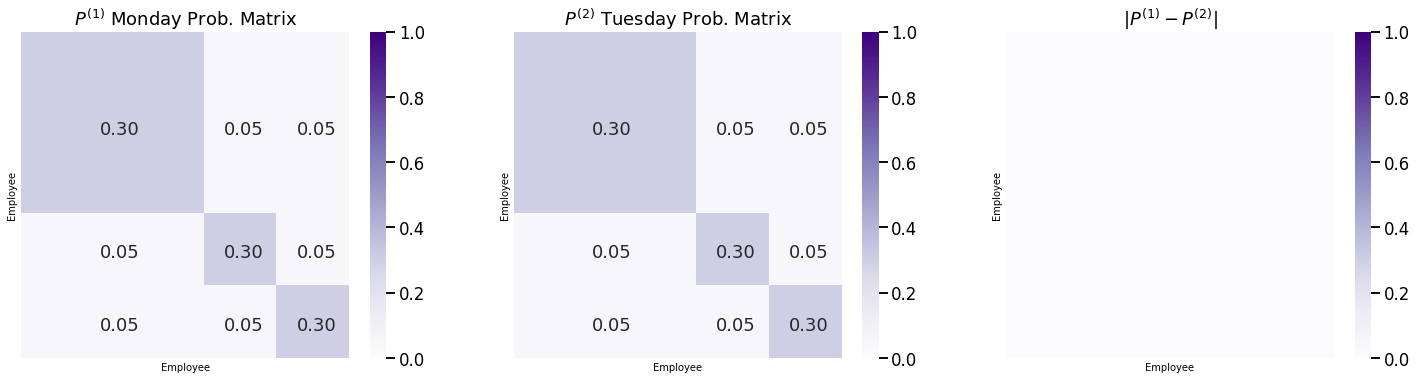

In [2]:
import seaborn as sns
from graphbook_code import cmaps
import pandas as pd

def p_from_block(B, ns):
    P = np.zeros((np.sum(ns), np.sum(ns)))
    ns_cumsum = np.append(0, np.cumsum(ns))
    for k, n1 in enumerate(ns_cumsum[0:(len(ns_cumsum)-1)]):
        for l, n2 in enumerate(ns_cumsum[k:(len(ns_cumsum)-1)]):
            P[ns_cumsum[k]:ns_cumsum[k+1], ns_cumsum[l+k]:ns_cumsum[l+k+1]] = B[k,l+k]
            P[ns_cumsum[l+k]:ns_cumsum[l+k+1],ns_cumsum[k]:ns_cumsum[k+1]] = B[l+k,k]
    return P

P1 = p_from_block(B1, ns)
U1, S1, V1 = np.linalg.svd(P1)
X1 = U1[:,0:3] @ np.sqrt(np.diag(S1[0:3]))

P2 = p_from_block(B2, ns)
U2, S2, V2 = np.linalg.svd(P2)
X2 = U2[:,0:3] @ np.sqrt(np.diag(S2[0:3]))

P3 = p_from_block(B3, ns)
U3, S3, V3 = np.linalg.svd(P3)
X3 = U3[:,0:3] @ np.sqrt(np.diag(S3[0:3]))

def plot_prob_block_annot(X, title="", nodename="Employee", nodetix=None,
             nodelabs=None, ax=None, annot=True):
    if (ax is None):
        fig, ax = plt.subplots(figsize=(8, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        if annot:
            X_annot = np.empty(X.shape, dtype='U4')
            X_annot[13, 13] = str("{:.3f}".format(X[13,13]))
            X_annot[30, 30] = str("{:.3f}".format(X[30,30]))
            X_annot[40,40] = str("{:.3f}".format(X[40,40]))
            X_annot[13, 30] = str("{:.3f}".format(X[13,30]))
            X_annot[30,13] = str("{:.3f}".format(X[30,13]))
            X_annot[13,40] = str("{:.3f}".format(X[23,40]))
            X_annot[40,13] = str("{:.3f}".format(X[40,13]))
            X_annot[30,40] = str("{:.3f}".format(X[30,40]))
            X_annot[40,30] = str("{:.3f}".format(X[40,30]))
            ax = sns.heatmap(X, cmap="Purples",
                            ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                            xticklabels=False, vmin=0, vmax=1, annot=pd.DataFrame(X_annot),
                            fmt='')
        else:
            ax = sns.heatmap(X, cmap="Purples",
                            ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                            xticklabels=False, vmin=0, vmax=1)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=nodename, xlabel=nodename)
        if (nodetix is not None) and (nodelabs is not None):
            ax.set_yticks(nodetix)
            ax.set_yticklabels(nodelabs)
            ax.set_xticks(nodetix)
            ax.set_xticklabels(nodelabs)
        cbar.ax.set_frame_on(True)
    return

fig, axs = plt.subplots(1,3, figsize=(25, 6))
plot_prob_block_annot(P1, ax=axs[0], title="$P^{(1)}$ Monday Prob. Matrix")
plot_prob_block_annot(P2, ax=axs[1], title="$P^{(2)}$ Tuesday Prob. Matrix")
plot_prob_block_annot(np.abs(P1 - P2), ax=axs[2], annot=False, title="$|P^{(1)} - P^{(2)}|$")

The Joint Random Dot Product Graphs (JRDPG) is the simplest way we can extend the RDPG random network model to multiple random networks. The way we can think of the JRDPG model is that for each of our $N$ total random neworks, the edges depend on a latent position matrix $X$. We say that a collection of random networks $\left\{\mathbf A^{(1)}, ..., \mathbf A^{(N)}\right\}$ with $n$ nodes is $JRDPG_n(X)$ if each random network $\mathbf A^{(m)}$ is $RDPG_n(X)$ and if the $N$ networks are independent.

### The JRDPG model does not allow us to convey unique aspects about the networks

Under the JRDPG model, each of the $N$ random networks share the same latent position matrix. Remember that for an RDPG, the probability matrix $P = XX^\top$. This means that for all of the $N$ networks, $P^{(m)} = XX^\top$ under the JRDPG model. hence, $P^{(1)} = P^{(2)} = ... = P^{(N)}$, and *all* of the probability matrices are *identical*! This means that the $N$ random networks are **homogeneous**.

For an RDPG, since $P = XX^\top$, the probability matrix depends *only* on the latent positions $X$. This means that we can tell whether a collection of networks are homogeneous just by looking at the latent position matrices! It turns out that the random networks underlying the realizations for the email networks in our given example were just SBMs. From the section on [Random Dot Product Graphs](#link?), we learned that SBMs are just RDPGs with a special latent position matrix. Let's try this first by looking at the latent position matrices for $\mathbf A^{(1)}$ and $\mathbf A^{(2)}$ from the random networks for Monday and Tuesday first:

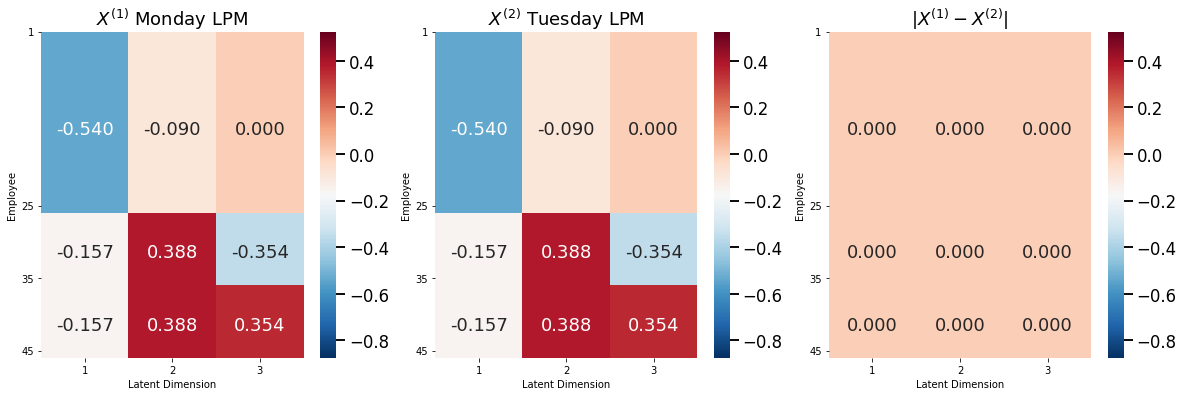

In [3]:
from numpy.linalg import svd

def plot_latent(X, title="", nodename="Employee", ylabel="Latent Dimension",
                nodetix=None, vmin=None, vmax=None, nodelabs=None, ax=None, dimtix=None, dimlabs=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        lim_max = np.max(np.abs(X))
        if vmin is None:
            vmin = -lim_max
        if vmax is None:
            vmax = lim_max
        X_annot = np.empty((45, 3), dtype='U6')
        X_annot[13,0] = str("{:.3f}".format(X[13,0]))
        X_annot[30,0] = str("{:.3f}".format(X[30,0]))
        X_annot[40,0] = str("{:.3f}".format(X[40,0]))
        X_annot[13,1] = str("{:.3f}".format(X[13,1]))
        X_annot[30,1] = str("{:.3f}".format(X[30,1]))
        X_annot[40,1] = str("{:.3f}".format(X[40,1]))
        X_annot[13,2] = str("{:.3f}".format(X[13,2]))
        X_annot[30,2] = str("{:.3f}".format(X[30,2]))
        X_annot[40,2] = str("{:.3f}".format(X[40,2]))
        ax = sns.heatmap(X, cmap=cmaps["divergent"],
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=vmin, vmax=vmax,
                        annot=X_annot, fmt='')
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=nodename, xlabel=ylabel)
        if (nodetix is not None) and (nodelabs is not None):
            ax.set_yticks(nodetix)
            ax.set_yticklabels(nodelabs)
        if (dimtix is not None) and (dimlabs is not None):
            ax.set_xticks(dimtix)
            ax.set_xticklabels(dimlabs)
        cbar.ax.set_frame_on(True)
    return

fig, axs = plt.subplots(1,3, figsize=(20, 6))
vmin = np.min([X1,X2,X3]); vmax = np.max([X1, X2, X3])
plot_latent(X1, nodetix=[0,24,34,44], vmin=vmin, vmax=vmax, nodelabs=["1", "25", "35", "45"],
            dimtix=[0.5,1.5,2.5], ax=axs[0], dimlabs=["1", "2", "3"], title="$X^{(1)}$ Monday LPM")
plot_latent(X2, nodetix=[0,24,34,44], nodelabs=["1", "25", "35", "45"],
            dimtix=[0.5,1.5,2.5], ax=axs[1], vmin=vmin, vmax=vmax, dimlabs=["1", "2", "3"], title="$X^{(2)}$ Tuesday LPM")
plot_latent(np.abs(X1 - X2), nodetix=[0,24,34,44], vmin=vmin, vmax=vmax, nodelabs=["1", "25", "35", "45"],
            dimtix=[0.5,1.5,2.5], ax=axs[2], dimlabs=["1", "2", "3"], title="$|X^{(1)} - X^{(2)}|$")

So the latent position matrices for Monday and Tuesday are exactly identical. Therefore, the collection of random networks $\left\{\mathbf A^{(1)}, \mathbf A^{(2)}\right\}$ are homogeneous, and we could model this pair of networks using the JRDPG.

What about Wednesday? Well, as it turns out, Wednesday had a *different* latent position matrix from both Monday and Tuesday:

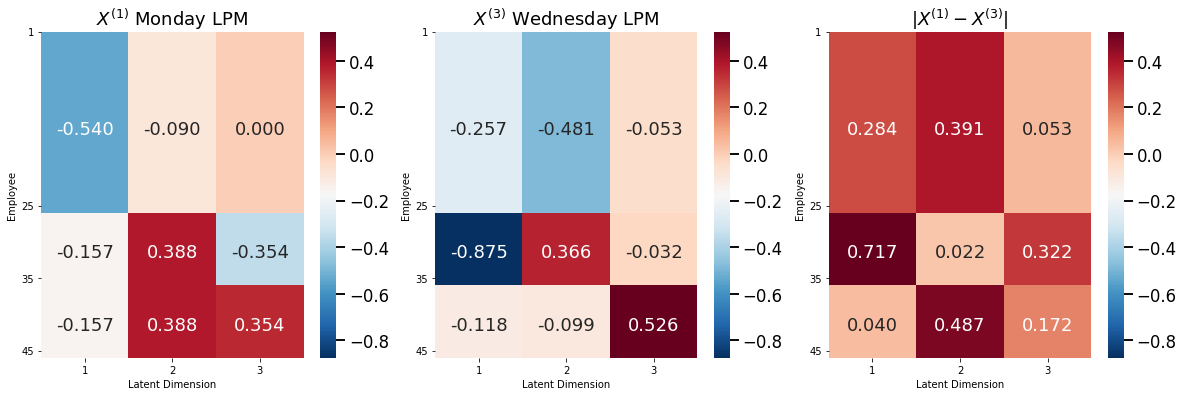

In [4]:
fig, axs = plt.subplots(1,3, figsize=(20, 6))
vmin = np.min([X1,X2,X3]); vmax = np.max([X1, X2, X3])
plot_latent(X1, nodetix=[0,24,34,44], vmin=vmin, vmax=vmax, nodelabs=["1", "25", "35", "45"],
            dimtix=[0.5,1.5,2.5], ax=axs[0], dimlabs=["1", "2", "3"], title="$X^{(1)}$ Monday LPM")
plot_latent(X3, nodetix=[0,24,34,44], nodelabs=["1", "25", "35", "45"],
            dimtix=[0.5,1.5,2.5], ax=axs[1], vmin=vmin, vmax=vmax, dimlabs=["1", "2", "3"], title="$X^{(3)}$ Wednesday LPM")
plot_latent(np.abs(X1 - X3), nodetix=[0,24,34,44], vmin=vmin, vmax=vmax, nodelabs=["1", "25", "35", "45"],
            dimtix=[0.5,1.5,2.5], ax=axs[2], dimlabs=["1", "2", "3"], title="$|X^{(1)} - X^{(3)}|$")

So, $\mathbf A^{(1)}$ and $\mathbf A^{(3)}$ do not have the same latent position matrices. This means that the collections of random networks $\left\{\mathbf A^{(1)}, \mathbf A^{(3)}\right\}$, $\left\{\mathbf A^{(2)}, \mathbf A^{(3)}\right\}$, and $\left\{\mathbf A^{(1)}, \mathbf A^{(2)}, \mathbf A^{(3)}\right\}$ are *heterogeneous*, because their probability matrices will be different. So, unfortunately, the JRDPG cannot handle the hetereogeneity between the random networks of Monday and Tuesday with the random network for Wednesday. To remove this restrictive homogeneity property of the JRDPG, we will need a new single network model, called the Inhomogeneous Erdos-Renyi (IER) random network model. 

### The Inhomogeous Erdos-Renyi (IER) Random Network

The IER random network is the most general random network model for a binary graph. The way we can think of the $IER$ random network is that a probability matrix $P$ with $n$ rows and $n$ columns defines each of the edge-existence probabilities for pairs of nodes in the network. For each pair of nodes $i$ and $j$, we have a unique coin which has a $p_{ij}$ chance of landing on heads, and a $1 - p_{ij}$ chance of landing on tails. If the coin lands on heads, the edge between nodes $i$ and $j$ exists, and if the coin lands on tails, the edge between nodes $i$ and $j$ does not exist. This coin flip is performed independently of the coin flips for all of the other edges. If $\mathbf A$ is a random network which is $IER$ with a probability matrix $P$, we say that $\mathbf A$ is an $IER_n(P)$ random network.

As before, we can develop a procedure to produce for us a network $A$, which has nodes and edges, where the underlying random network $\mathbf A$ is an $IER_n(P)$ random network:

```{admonition} Simulating a realization from an $IER_n(P)$ random network
1. Determine a probability matrix $P$, whose entries $p_{ij}$ are probabilities.
2. For each pair of nodes $i$ an $j$:
    * Obtain a weighted coin $(i,j)$ which has a probability $p_{ij}$ of landing on heads, and a $1 - p_{ij}$ probability of landing on tails.
    * Flip the $(i,j)$ coin, andd if it lands on heads, the corresponding entry $a_{ij}$ in the adjacency matrix is $1$. If the coin lands on tails, the corresponding entry $a_{ij}$ is $0$. 
3. The adjacency matrix we produce, $A$, is a realization of an $IER_n(P)$ random network. 
```

It is important to realize that all of the networks we have described so far are also $IER_n(P)$ random networks. The previous single network models we have described to date simply place restrictions on the way in which we acquire $P$. For instance, in an $ER_n(p)$ random network, all entries $p_{ij}$ of $P$ are equal to $p$. To see that an $SBM_n(\vec z, B)$ random network is also $IER_n(P)$, we can construct the probability matrix $P$ such that $p_{ij} = b_{kl}$ of the block matrix $B$ when the community of node $i$ $z_i = k$ and the community of node $j$ $z_j = l$. To see that an $RDPG_n(X)$ random network is also $IER_n(P)$, we can construct the probability matrix $P$ such that $P = XX^\top$. This shows that the IER random network is the most general of the single network models we have studied so far. Next, let's see how the IER random network can help us address this heterogeneity.

## Common Subspace Independent Edge (COSIE) Model


In our example on email networks, notice that the Monday and Wednesday emails looked relatively similar, but had an important difference: on Wednesday, there was an administrative meeting, and the employees on the administrative team exchanged far more emails than usual amongst one another. It turns out that, in fact, the random networks $\mathbf A^{(1)}$ and $\mathbf A^{(3)}$ which underly the email networks $A^{(1)}$ and $A^{(3)}$ were also different, because the probability matrices were different:

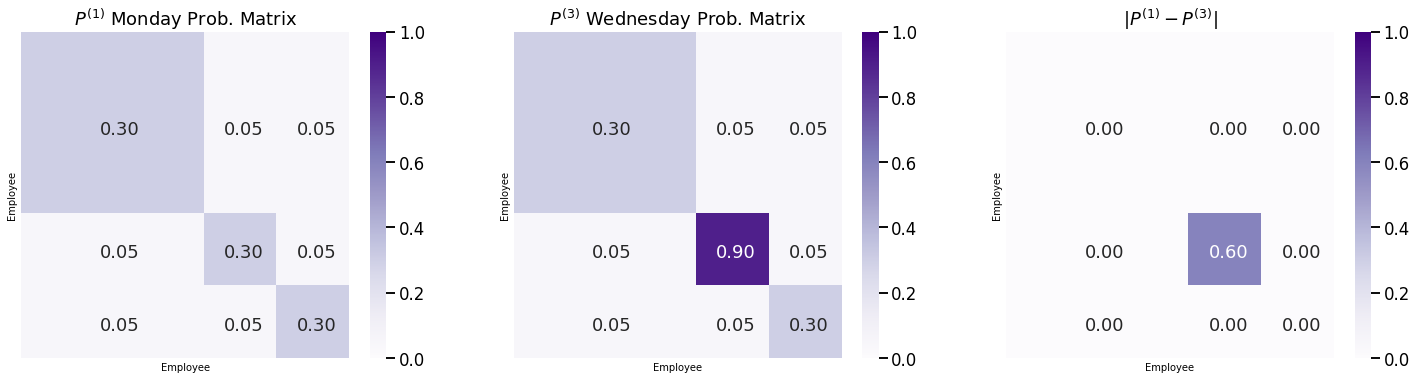

In [5]:
fig, axs = plt.subplots(1,3, figsize=(25, 6))
plot_prob_block_annot(P1, ax=axs[0], title="$P^{(1)}$ Monday Prob. Matrix")
plot_prob_block_annot(P3, ax=axs[1], title="$P^{(3)}$ Wednesday Prob. Matrix")
plot_prob_block_annot(np.abs(P1 - P3), ax=axs[2], annot=True, title="$|P^{(1)} - P^{(3)}|$")

Notice that the difference in the probability of an email being exchanged between the members of the administrative team is $0.6$ higher in the probability matrix for Wednesday than for Monday. This is because the random networks $\mathbf A^{(1)}$ and $\mathbf A^{(3)}$ are heterogeneous. To reflect this heterogeneity, we will need to turn to the COmmon Subspace Independent Edge (COSIE) model.

### The COSIE Model is defined by a collection of score matrices and a shared low-rank subspace

Even though $P^{(1)}$ and $P^{(3)}$ are not *identical*, we can see they still share *some* structure: the employee teams are the same between the two email networks, and much of the probability matrix is unchanged. For this reason, it will be useful for us to have a network model which allows us to convey *some* shared structure, but still lets us convey aspects of the different networks which are *unique*. The COSIE model will accomplish this using a *shared latent position matrix*, and unique *score matrices* for each of the random networks.

#### The Shared Latent Position Matrix Describes Similarities

The *shared latent position matrix* for the COSIE model is quite similar to the latent position matrix for an RDPG. Like the latent position matrix, the shared latent position matrix $V$ is a matrix with $n$ rows (one for each node) and $d$ columns. The $d$ columns behave very similarly to the $d$ columns ffor the latent position matrix of an RDPG, and $d$ is referred to as the *latent dimensionality* of the COSIE random networks. Like before, each row of the shared latent position matrix $v_i$ will be referred to as the shared latent position vector for node $i$.

We will also add an additional restriction to $V$: it will be a matrix with orthonormal columns. What this means is that for each column of $V$, the dot product of the column with itself is $1$, and the dot product of the column with any other column is $0$. This has the implication that $V^\top V = I$, the identity matrix. 

The shared latent position matrix conveys the *common structure* between the COSIE random networks, and will be a parameter for each of the neworks. Remember that with the $JRDPG_n(X)$ model, we were able to capture the homogeneity of the email networks on Monday and Tuesday, but we could not capture the heterogeneity of the email nework on Wednesday. However, we want the shared latent position matrix $V$ to convey the commonality amongst the three email networks; that is, that the employees are are always working on the same employee teams. Let's take a look at the shared latent position matrix $V$ for the email example:

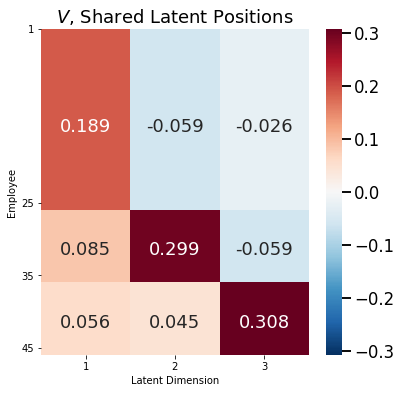

In [6]:
from graspologic.embed import MultipleASE as MASE

embedder = MASE(n_components=3)
V = embedder.fit_transform([P1, P2, P3])

plot_latent(V, nodetix=[0,24,34,44], nodelabs=["1", "25", "35", "45"],
            dimtix=[0.5,1.5,2.5], dimlabs=["1", "2", "3"], title="$V$, Shared Latent Positions")

$V$ reflects the fact that the first $25$ employees are the ML experts, and all $25$ have the same latent position vector. The next $10$ employees are the administrative members, and share a different latent position vector from the ML experts. Finally, the last $10$ employees are the marketing members, share a different latent position vector from the ML experts and the administrative team. In this way, the orthonormal matrix $V$ has conveyed the community structure (the employee roles and who they tend to email amongst) that is shared across all three days.

#### Score Matrices Describe Differences

The *score matrices* for the COSIE random networks essentially tell us how to assemble the shared latent position matrix to obtain the unique probability matrix for each network. The score matrix $R^{(m)}$ for a random network $m$ is a matrix with $d$ columns and $d$ rows. Therefore, it is a square matrix whose number of dimensions is equal to the latent dimensionality of the COSIE random networks.

The probability matrix for each network under the COSIE model is the matrix:
\begin{align*}
    P^{(m)} &= VR^{(m)}V^\top
\end{align*}

In our email example, we want the score matrices to reflect that Monday and Tuesday share a probability matrix, but Monday and Wednesday do not. Consequently, we would expect that the score matrices from Monday and Tuesday should be the same, but the score matrix for Wednesday will be different:

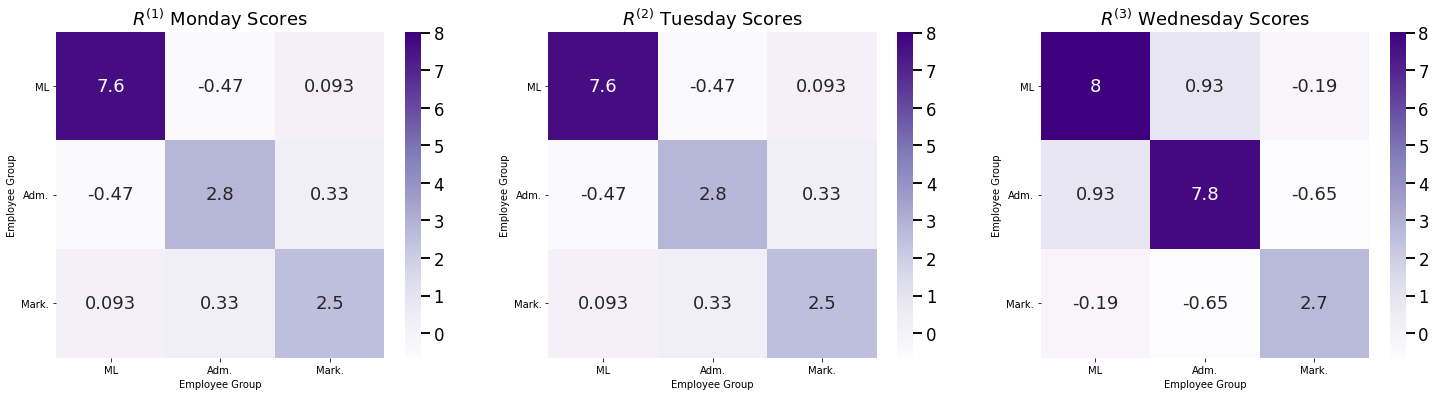

In [7]:
def plot_score(X, title="", blockname="Employee Group", blocktix=[0.5, 1.5, 2.5],
               blocklabs=["ML", "Adm.", "Mark."], ax=None, vmin=0, vmax=1):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=vmin, vmax=vmax, annot=True)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=blockname, xlabel=blockname)
        ax.set_yticks(blocktix)
        ax.set_yticklabels(blocklabs)
        ax.set_xticks(blocktix)
        ax.set_xticklabels(blocklabs)
        cbar.ax.set_frame_on(True)
    return

vmin=np.min(embedder.scores_); vmax = np.max(embedder.scores_)

fig, axs = plt.subplots(1,3, figsize=(25, 6))
R1 = embedder.scores_[0,:,:]
R2 = embedder.scores_[1,:,:]
R3 = embedder.scores_[2,:,:]

plot_score(R1, ax=axs[0], vmin=vmin, vmax=vmax, title="$R^{(1)}$ Monday Scores")
plot_score(R2, ax=axs[1], vmin=vmin, vmax=vmax, title="$R^{(2)}$ Tuesday Scores")
plot_score(R3, ax=axs[2], vmin=vmin, vmax=vmax, title="$R^{(3)}$ Wednesday Scores")

As we can see, the scores $R^{(1)}$ and $R^{(2)}$ are the same for Monday and Tuesday, but different for $R^{(3)}$ Wednesday.

Finally, let's relate all of this back to the COSIE model. The way we can think about the COSIE model is that for each random network $m$ of our $N$ total networks, the probability matrix $P^{((m)}$ depends on the shared latent position matrix $V$ and the score matrix $R^{(m)}$. The probability matrix $P^{(m)}$ for the $m^{th}$ random network is defined so that $P^{(m)} = VR^{(m)}V^\top$. This means that each entry $p_{ij}^{(m)} = \vec v_i^\top R^{(m)} \vec v_j$. We say that a collection of random networks $\left\{\mathbf A^{(1)}, ..., \mathbf A^{(N)}\right\}$ with $n$ nodes is $COSIE_n\left(V, \left\{R^{(1)},...,R^{(N)}\right\}\right)$ if each random network $\mathbf A^{(m)}$ is $IER(P^{(m)})$. Stated another way, each of the $N$ random networks share the same orthonormal matrix $V$, but a unique score matrix $R^{(m)}$. This allows the random networks to share some underlying structure (which is conveyed by $V$) but each random network still has a combination of this shared structure (conveyed by $R^{(m)}$). 

Since the probability matrix $P^{(m)} = VR^{(m)}V^\top$, we can see that two random networks with the same score matrix will be homogeneous, and two random networks with different score matrices will be heterogeneous. In this way, we were able to capture the homogeneity between the random networks for Monday and Tuesday emails, while also capturing the heterogeneity between the random networks for Monday and Wednesday emails. 

## Correlated Network Models

Finally, we get to a special case of network models, known as correlated network models. Let's say that we have a group of people in a city, and we know that each people in our group have both a Facebook and a Twitter. The nodes in our network are the people we have. The first network consists of Facebook connections amongst the people, where an edge exists between two people if they are friends on Facebook. The second network consists of Twitter connections amongst the people, where an edge exists between two people if they follow one another on Twitter. We think that if two people are friends on Facebook, there is a good chance that they follow one another on Twitter, and vice versa. How do we reflect this similarity through a multiple network model?

At a high level, network correlation between a pair of networks describes the property that the existence of edges in one network provides us with some level of information about edges in the other network, much like the Facebook/Twitter example we just discussed. In this book, we will focus on the $\rho$-*correlated* network models. What the $\rho$-correlated network models focus on is that given two random networks with the same number of nodes, each edge has a correlation of $\rho$ between the two networks. To define this a little more rigorously, a pair of random networks $\mathbf A^{(1)}$ and $\mathbf A^{(2)}$ are called $\rho$-**correlated** if all of the edges across both networks are mutually independent, except that for all pairs of indices $i$ and $j$, $corr(\mathbf a_{ij}^{(1)}, \mathbf a_{ij}^{(2)}) = \rho$, where $corr(\mathbf x, \mathbf y)$ is the Pearson correlation between two random variables $\mathbf x$ and $\mathbf y$. In our example, this means that whether two people are friends on Facebook is *correlated* with whether they are following one another on Twitter.

At a high level, the Pearson correlation describes whether one variable being large/small gives information that the other variable is large/small (positive correlation, between $0$ and $1$) or whether one variable being large/small gives information that the other variable will be small/large (negative correlation, between $-1$ and $0$). If the two networks are positively correlated and we know that one of the edges $\mathbf a_{ij}^{(1)}$ has a value of one, then we have information that $\mathbf a_{ij}^{(2)}$ might also be one, and vice-versa for taking values of zero. If the two networks are negatively correlated and we know that one of the edges $\mathbf a_{ij}^{(1)}$ has a value of one, then we have information that $\mathbf a_{ij}^{(2)}$ might be zero, and vice-versa. If the two networks are not correlated ($\rho = 0$) we do not learn anything about edges of network two by looking at edges from network one.

### $\rho$-Correlated RDPG

The $\rho$-correlated RDPG is the most general correlated network model we will need for the purposes of this book. Remembering that both ER and SBM random networks are special cases of the RDPG (for a given choice of the latent position matrix), the $\rho$-correlated RDPG can therefore be used to construct $\rho$-correlated ER and $\rho$-correlated SBMs, too. The way we can think about the $\rho$-correlated RDPG is that like for the normal RDPG, a latent position matrix $X$ with $n$ rows and a latent dimensionality of $d$ is used to define the edge-existence probabilities for the networks $\mathbf A^{(1)}$ and $\mathbf A^{(2)}$. We begin by defining that $\mathbf A^{(1)}$ is $RDPG_n(X)$. Next, we define the second network as follows. We use a coin for each edge $(i, j)$, which has a probability that depends on the values that the first network takes. If the edge $\mathbf a_{ij}^{(1)}$ takes the value of one, then we use a coin which has a probability of landing on heads of $\vec x_i^\top \vec x_j + \rho(1 - \vec x_i^\top \vec x_j)$. If the edge $\mathbf a_{ij}^{(1)}$ takes the value of zero, then we use a coin which has a probability of landing on heads of $(1 - \rho)\vec x_i^\top \vec x_j$. We flip this coin, and if it lands on heads, then the edge $\mathbf a_{ij}^{(2)}$ takes the value of one. If it lands on tails, then the edge $\mathbf a_{ij}^{(2)}$ takes the value of zero. If $\mathbf A^{(1)}$ and $A^{(2)}$ are random networks which are $\rho$-correlated RDPGs with latent position matrix $X$, we say that the pair $\left\{\mathbf A^{(1)}, A^{(2)}\right\}$ are $\rho-RDPG_n(X)$. 

```{admonition} Simulating realizations of $\rho$-correlated RDPGs
1. Determine a latent position matrix $X$, where rows $\vec x_i$ are the latent position vectors for the nodes $i$.
2. Determine a correlation between the two networks of $\rho$, where $\rho \geq -1$ and $\rho \leq 1$.
3. Simulate a realization $A^{(1)}$ which is a realization  of an $RDPG_n(X)$ random network.
4. For each pair of nodes $i$ and $j$:
    * If the edge $a_{ij}^{(1)}$ has a value of one, obtain a coin which has a probability of landing on heads of $\vec x_i^\top \vec x_j + \rho(1 - \vec x_i^\top \vec x_j)$. If the edge $a_{ij}^{(2)}$ has a value of zero, obtain a coin which has a probability of landing on heads of $(1 - \rho)\vec x_i^\top \vec x_j$.
    * Flip the $(i,j)$ coin, andd if it lands on heads, the corresponding entry $a_{ij}^{(2)}$ in the adjacency matrix is $1$. If the coin lands on tails, the corresponding entry $a_{ij}^{(2)}$ is $0$. 
5. The adjacency matrices $A^{(1)}$ and $A^{(2)}$ are realizations of $\rho-RDPG_n(X)$ random networks.
```

Fortunately, graspologic makes sampling $\rho$-correlated RDPGs relatively simple. Let's say that in our Facebook/Twitter example, we have $100$ people across two schools, like our standard example from the SBM section. The first $50$ students attend school one, and the second $50$ students attend school two. To recap, the latent position matrix looks like this:

In [8]:
import numpy as np
from numpy.linalg import svd

n = 100

# deine a probability matrix for a stochastic block model with two communities
# where the first 50 students are from community one and the second 50 students are
# from community two
P = np.zeros((n,n))
P[0:50,0:50] = .5
P[50:100, 50:100] = .3
P[0:50,50:100] = .2
P[50:100,0:50] = .2

# use the singular value decomposition to obtain the corresponding latent
# position matrix
U, S, V = svd(P)
X = U[:,0:2] @ np.sqrt(np.diag(S[0:2]))

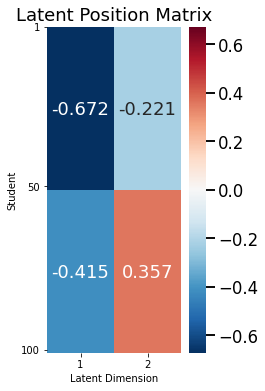

In [9]:
from graphbook_code import cmaps
import matplotlib.pyplot as plt
import seaborn as sns

def plot_latent(X, title="", nodename="Student", ylabel="Latent Dimension",
                nodetix=None, nodelabs=None, dimtix=None, dimlabs=None):
    fig, ax = plt.subplots(figsize=(3, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        lim_max = np.max(np.abs(X))
        vmin = -lim_max; vmax = lim_max
        X_annot = np.empty((100, 2), dtype='U6')
        X_annot[25,0] = str("{:.3f}".format(X[25,0]))
        X_annot[75,0] = str("{:.3f}".format(X[75,0]))
        X_annot[25,1] = str("{:.3f}".format(X[25,1]))
        X_annot[75,1] = str("{:.3f}".format(X[75,1]))
        ax = sns.heatmap(X, cmap=cmaps["divergent"],
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=vmin, vmax=vmax,
                        annot=X_annot, fmt='')
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=nodename, xlabel=ylabel)
        if (nodetix is not None) and (nodelabs is not None):
            ax.set_yticks(nodetix)
            ax.set_yticklabels(nodelabs)
        if (dimtix is not None) and (dimlabs is not None):
            ax.set_xticks(dimtix)
            ax.set_xticklabels(dimlabs)
        cbar.ax.set_frame_on(True)
    return


ax = plot_latent(X, title="Latent Position Matrix", nodetix=[0, 49, 99],
              nodelabs=["1", "50", "100"], dimtix=[0.5,1.5], dimlabs=["1", "2"])

To sample two networks which are $\rho$-correlated SBMs, let's assume that the correlation between the two networks is high, so we will assume $\rho = 0.7$. We use the graspologic function to obtain a realization for each network. We show the two networks, as well as the edges which are different between the two networks. We summarize this edge difference plot with $diff(A^{(F)} - A^{(T)})$, which simply counts the number of edges which are different: 

In [10]:
from graspologic.simulations import rdpg_corr

rho = 0.7
A_facebook, A_twitter = rdpg_corr(X, Y=None, r=rho, directed=False, loops=False)

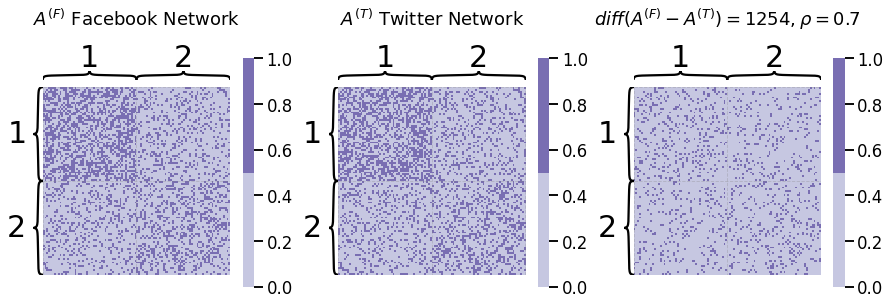

In [11]:
fig, axs = plt.subplots(1,3, figsize=(15, 6))

ys = ["1" for i in range(0, 50)] + ["2" for i in range(0, 50)]

heatmap(A_facebook, ax=axs[0], title="$A^{(F)}$ Facebook Network", color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);

heatmap(A_twitter, ax=axs[1], title="$A^{(T)}$ Twitter Network", color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);

heatmap(np.abs(A_facebook - A_twitter), ax=axs[2], title="$diff(A^{(F)} - A^{(T)}) = %d, \\rho = 0.7$" % np.abs(A_facebook - A_twitter).sum(), 
        color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);

On the other hand, if the correlation were $\rho = 0$ (the two networks are uncorrelated), we can see that the number of edges which are different is much higher:

In [12]:
rho = 0.0
A_facebook, A_twitter = rdpg_corr(X, Y=None, r=rho, directed=False, loops=False)

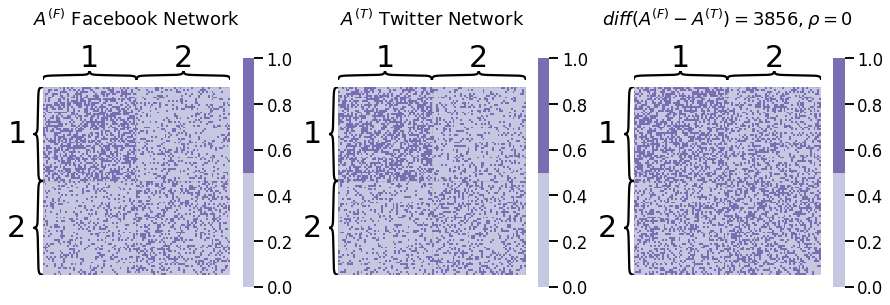

In [13]:
fig, axs = plt.subplots(1,3, figsize=(15, 6))

ys = ["1" for i in range(0, 50)] + ["2" for i in range(0, 50)]

heatmap(A_facebook, ax=axs[0], title="$A^{(F)}$ Facebook Network", color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);

heatmap(A_twitter, ax=axs[1], title="$A^{(T)}$ Twitter Network", color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);

heatmap(np.abs(A_facebook - A_twitter), ax=axs[2], title="$diff(A^{(F)} - A^{(T)}) = %d, \\rho = 0$" % np.abs(A_facebook - A_twitter).sum(),
        color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);